# Import libraries and prepare data

In [103]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.nonparametric.smoothers_lowess import lowess
import plotly.express as px

In [24]:
# get the path to the data, not in the same location as the jupyter notebook
pathName = os.path.abspath(os.getcwd()) + "\\city-of-toronto-data\\"

fn_turn_restrict1718 = r"i0456_king_st_tmc_turn_restrictions2017_2018.csv"
fn_turn_restrict1923 = r"i0456_king_st_tmc_turn_restrictions2019_2023.csv"
fn_intersections = r"intersections_10-20.csv"

# create dataframes from csv
df_turn_restrict1718 = pd.read_csv(pathName + fn_turn_restrict1718, parse_dates=["dt_hourly"])
df_turn_restrict1923 = pd.read_csv(pathName + fn_turn_restrict1923, parse_dates=["dt_hourly"])
df_intersections = pd.read_csv(pathName + fn_intersections)

## Preparing data

In [25]:

# set dtypes
df_turn_restrict1718['e_thru_vol'] = df_turn_restrict1718['e_thru_vol'].apply(np.int64)
df_turn_restrict1923['e_left_vol'] = df_turn_restrict1923['e_left_vol'].astype('Int64')
df_turn_restrict1923['w_right_vol'] = df_turn_restrict1923['w_right_vol'].astype('Int64')

# merge to get intersection name
df_2017_2018 = pd.merge(df_turn_restrict1718, df_intersections[["intersection_uid", "intersection_name"]], on="intersection_uid")
df_2019_2023 = pd.merge(df_turn_restrict1923, df_intersections[["intersection_uid", "intersection_name"]], on="intersection_uid")

# create date and hour columns
df_2017_2018["date"] = df_2017_2018["dt_hourly"].apply(lambda x: x.date())
df_2017_2018["hour"] = df_2017_2018["dt_hourly"].apply(lambda x: x.hour)
df_2019_2023["date"] = df_2019_2023["dt_hourly"].apply(lambda x: x.date())
df_2019_2023["hour"] = df_2019_2023["dt_hourly"].apply(lambda x: x.hour)

## Filtering Data

### Taxi Mask

In [26]:
# Taxi Masks
TaxiMask1 = (df_2017_2018["hour"] >= 5) & (df_2017_2018["hour"] < 22)
df_2017_2018_nt = df_2017_2018[TaxiMask1].copy()

TaxiMask2 = (df_2019_2023["hour"] >= 5) & (df_2019_2023["hour"] < 22)
df_2019_2023_nt = df_2019_2023[TaxiMask2].copy()

### Intersection Filter

In [27]:
df_2017_2018_nt_Portland = df_2017_2018_nt[df_2017_2018_nt["intersection_uid"] == 11]
df_2019_2023_nt_Portland = df_2019_2023_nt[df_2019_2023_nt["intersection_uid"] == 11]

# Exploring Portland data

The intersection of King / Portland has the following restrictions:
- no E thru traffic
- no E left traffic
- no W thru traffic
- no W left turns

## Temporal Masks

### Pre-Pilot

In [28]:
MaskPrePilot = (df_2017_2018_nt['dt_hourly'] >= '2017-10-01') & (df_2017_2018_nt['dt_hourly'] < '2017-11-12')
df_PrePilot_nt_Portland = df_2017_2018_nt_Portland.loc[MaskPrePilot].copy().reset_index(drop=True)

### Pilot (2017-2018)

In [29]:
MaskPilot = (df_2017_2018_nt['dt_hourly'] >= '2017-11-12') & (df_2017_2018_nt['dt_hourly'] < '2018-08-25')
df_Pilot_nt_Portland = df_2017_2018_nt_Portland.loc[MaskPilot].copy().reset_index(drop=True)

### 2019

In [30]:
Mask2019 = (df_2019_2023_nt['dt_hourly'] >= '2019-01-01') & (df_2019_2023_nt['dt_hourly'] < '2020-01-01')
df_2019_nt_Portland = df_2019_2023_nt_Portland.loc[Mask2019].copy().reset_index(drop=True)

### 2020

In [31]:
Mask2020 = (df_2019_2023_nt['dt_hourly'] >= '2020-01-01') & (df_2019_2023_nt['dt_hourly'] < '2021-01-01')
df_2020_nt_Portland = df_2019_2023_nt_Portland.loc[Mask2020].copy().reset_index(drop=True)

### 2021

In [32]:
Mask2021 = (df_2019_2023_nt['dt_hourly'] >= '2021-01-01') & (df_2019_2023_nt['dt_hourly'] < '2022-01-01')
df_2021_nt_Portland = df_2019_2023_nt_Portland.loc[Mask2021].copy().reset_index(drop=True)

### 2022

In [33]:
Mask2022 = (df_2019_2023_nt['dt_hourly'] >= '2022-01-01') & (df_2019_2023_nt['dt_hourly'] < '2023-01-01')
df_2022_nt_Portland = df_2019_2023_nt_Portland.loc[Mask2022].copy().reset_index(drop=True)

### 2023

In [34]:
Mask2023 = (df_2019_2023_nt['dt_hourly'] >= '2023-01-01') & (df_2019_2023_nt['dt_hourly'] < '2024-01-01')
df_2023_nt_Portland = df_2019_2023_nt_Portland.loc[Mask2023].copy().reset_index(drop=True)

## Aggregation

In [35]:
allmvmt = ["e_thru_vol", "e_left_vol", "e_right_vol", "w_thru_vol", "w_left_vol", "w_right_vol"]
restrictedmvmtBathurst = ["e_thru_vol", "e_left_vol", "w_thru_vol"]
restrictedmvmtPortland = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtSpadina = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtPeter = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtJohn = ["e_left_vol", "w_left_vol"]
restrictedmvmtSimcoe = ["e_left_vol"]
restrictedmvmtUniversity = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtYork = ["w_left_vol"]
restrictedmvmtBay = ["e_left_vol", "w_left_vol"]
restrictedmvmtYonge = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtChurch = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtJarvis = ["e_thru_vol", "w_thru_vol", "w_left_vol"]

### All Results

In [101]:
results1 = df_2017_2018_nt_Portland[["date"] + allmvmt].groupby('date').aggregate("sum")
results1i = results1.reset_index()
results1i["date"] = pd.to_datetime(results1i["date"])

results2 = df_2019_2023_nt_Portland[["date"] + allmvmt].groupby('date').aggregate("sum")
results2i = results2.reset_index()
results2i["date"] = pd.to_datetime(results2i["date"])

results = pd.concat([results1i, results2i])
results["year"] = results["date"].dt.year
results["doy"] = results["date"].dt.dayofyear
results

,date,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol,year,doy
0,2017-10-30,4545,696,577,4604,762,525,2017,303
1,2017-10-31,5040,897,654,4656,809,524,2017,304
2,2017-11-01,5212,1007,649,4796,879,634,2017,305
3,2017-11-02,5655,1116,739,4636,832,732,2017,306
4,2017-11-03,4917,869,670,4776,884,641,2017,307
...,...,...,...,...,...,...,...,...,...
342,2020-06-10,408,36,647,184,11,343,2020,162
343,2020-06-11,572,33,754,236,16,367,2020,163
344,2020-06-12,553,37,737,269,18,362,2020,164
345,2020-06-13,564,32,711,464,28,402,2020,165


### Pre-Pilot

In [36]:
resultPrePilot = df_PrePilot_nt_Portland[["date"] + allmvmt].groupby('date').aggregate("sum")
resultPrePilot

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,
2017-10-30,4545,696,577,4604,762,525
2017-10-31,5040,897,654,4656,809,524
2017-11-01,5212,1007,649,4796,879,634
2017-11-02,5655,1116,739,4636,832,732
2017-11-03,4917,869,670,4776,884,641
2017-11-04,3764,599,610,4549,636,743
2017-11-05,3702,508,483,4281,506,517
2017-11-06,4472,706,637,4816,777,739
2017-11-07,4593,911,658,4262,731,512


### Pilot

In [37]:
resultPilot = df_Pilot_nt_Portland[["date"] + allmvmt].groupby('date').aggregate("sum")
resultPilot

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,
2017-12-04,428,17,1261,284,22,781
2017-12-05,493,29,1426,338,33,808
2017-12-06,511,25,1302,325,21,742
2017-12-07,683,41,1656,392,17,886
2017-12-08,621,29,1631,438,35,895
2017-12-09,710,39,1285,622,34,864
2017-12-10,463,30,935,385,18,735
2018-01-15,448,43,1124,308,24,607
2018-01-16,549,37,1176,384,31,636


### 2019

In [74]:
result2019 = df_2019_nt_Portland[["date"] + allmvmt].groupby('date').aggregate("sum")

result2019i = result2019.reset_index()
result2019i["date"] = pd.to_datetime(result2019i["date"])

### 2020

In [83]:
result2020 = df_2020_nt_Portland[["date"] + allmvmt].groupby('date').aggregate("sum")

# reset index turns date into a named column, removing multi-indexing, needed for altair
result2020i = result2020.reset_index()
result2020i["date"] = pd.to_datetime(result2020i["date"])
result2020i

,date,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
0,2020-05-24,337,17,354,306,14,294
1,2020-05-25,412,25,524,211,19,278
2,2020-05-26,441,23,619,228,15,322
3,2020-05-27,407,21,576,173,7,312
4,2020-05-28,490,28,692,206,16,356
5,2020-05-29,512,42,785,247,14,407
6,2020-05-30,559,21,559,471,24,408
7,2020-05-31,465,23,441,425,22,338
8,2020-06-01,401,27,596,225,11,325
9,2020-06-02,379,36,615,198,16,354


### 2021

In [40]:
result2021 = df_2021_nt_Portland[["date"] + allmvmt].groupby('date').aggregate("sum")
result2021

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,


### 2022

In [41]:
result2022 = df_2022_nt_Portland[["date"] + allmvmt].groupby('date').aggregate("sum")
result2022

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,


### 2023

In [42]:
result2023 = df_2023_nt_Portland[["date"] + allmvmt].groupby('date').aggregate("sum")
result2023

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,


## Visualizations

### Pre-Pilot

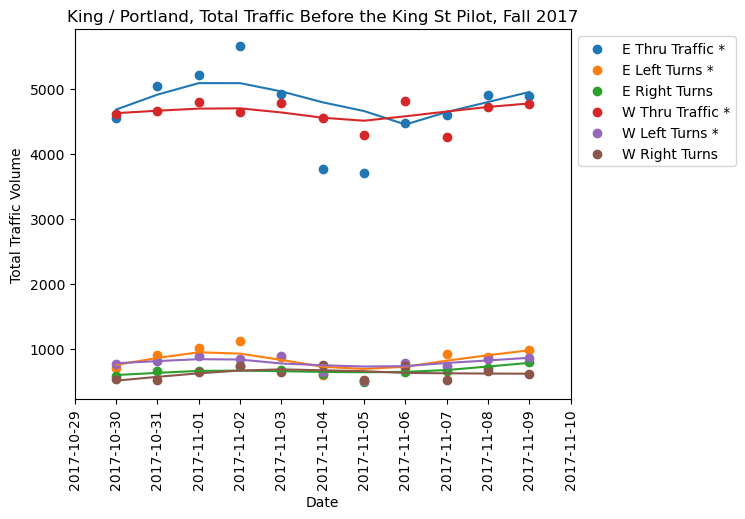

In [43]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x = pd.to_datetime(resultPrePilot.index) # this is date

# data
etv = plt.scatter(x, resultPrePilot.e_thru_vol)
elv = plt.scatter(x, resultPrePilot.e_left_vol)
erv = plt.scatter(x, resultPrePilot.e_right_vol)
wtv = plt.scatter(x, resultPrePilot.w_thru_vol)
wlv = plt.scatter(x, resultPrePilot.w_left_vol)
wrv = plt.scatter(x, resultPrePilot.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify the it parameter
filtered = lowess(resultPrePilot.e_thru_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.e_left_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.e_right_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.w_thru_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.w_left_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.w_right_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns *", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Portland, Total Traffic Before the King St Pilot, Fall 2017')
plt.xlabel('Date')
plt.ylabel('Total Traffic Volume')
plt.xticks(rotation=90)
# plt.ylim(0, 4000)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlim([datetime.date(2017, 10, 29), datetime.date(2017, 11, 10)])
plt.show()

### Pilot

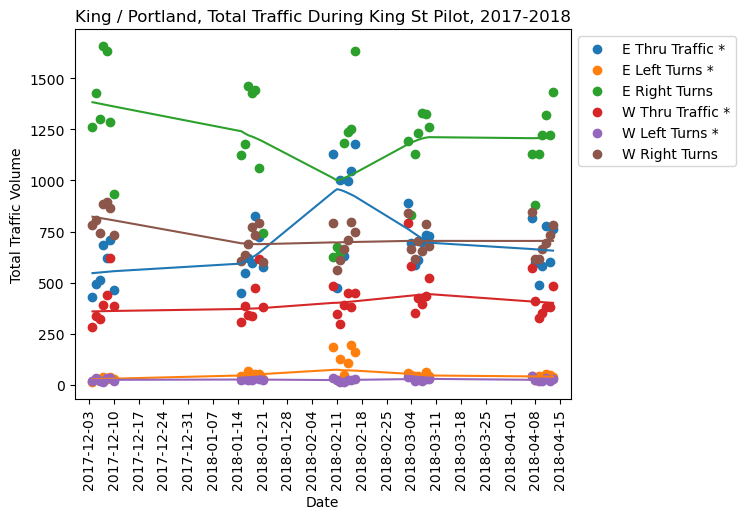

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x = pd.to_datetime(resultPilot.index) # this is date

# data
etv = plt.scatter(x, resultPilot.e_thru_vol)
elv = plt.scatter(x, resultPilot.e_left_vol)
erv = plt.scatter(x, resultPilot.e_right_vol)
wtv = plt.scatter(x, resultPilot.w_thru_vol)
wlv = plt.scatter(x, resultPilot.w_left_vol)
wrv = plt.scatter(x, resultPilot.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify the it parameter
filtered = lowess(resultPilot.e_thru_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.e_left_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.e_right_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.w_thru_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.w_left_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.w_right_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns *", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Portland, Total Traffic During King St Pilot, 2017-2018')
plt.xlabel('Date')
plt.ylabel('Total Traffic Volume')
plt.xticks(rotation=90)
# plt.ylim(0, 4000)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlim([datetime.date(2017, 11, 29), datetime.date(2018, 4, 18)])
plt.show()

### 2019

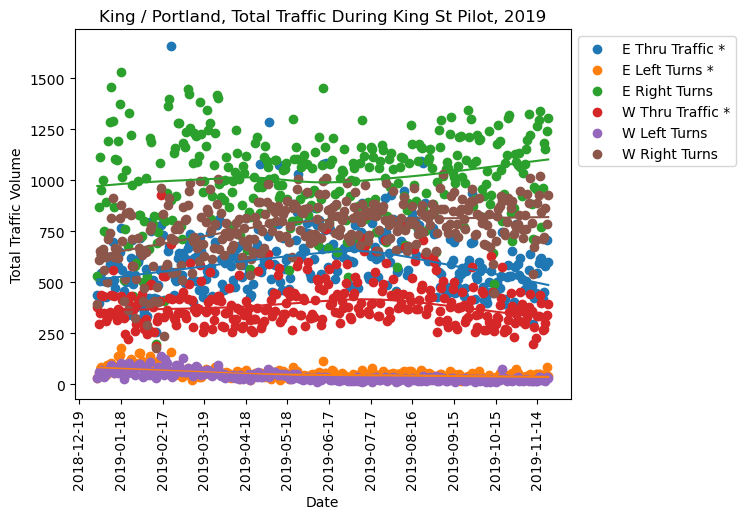

In [45]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
 
x = pd.to_datetime(result2019.index) # this is date

# data
etv = plt.scatter(x, result2019.e_thru_vol)
elv = plt.scatter(x, result2019.e_left_vol)
erv = plt.scatter(x, result2019.e_right_vol)
wtv = plt.scatter(x, result2019.w_thru_vol)
wlv = plt.scatter(x, result2019.w_left_vol)
wrv = plt.scatter(x, result2019.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify it parameter
filtered = lowess(result2019.e_thru_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.e_left_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.e_right_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.w_thru_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.w_left_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.w_right_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Portland, Total Traffic During King St Pilot, 2019')
plt.xlabel('Date')
plt.ylabel('Total Traffic Volume')
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

### 2020

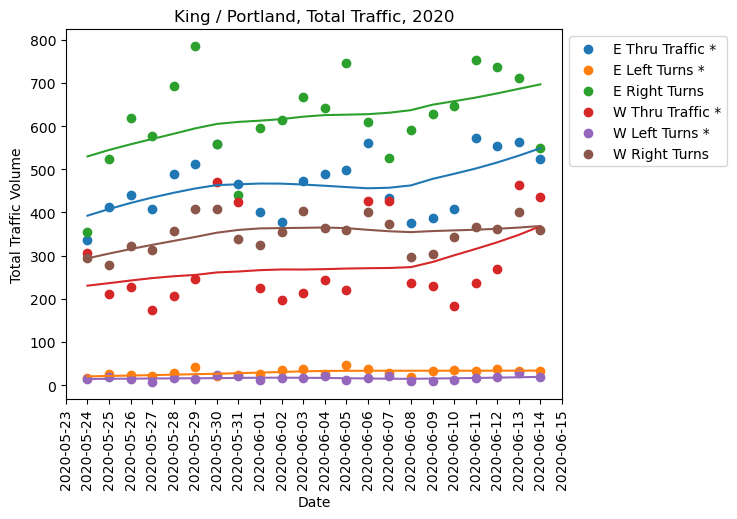

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
 
x = pd.to_datetime(result2020.index) # this is date

# data
etv = plt.scatter(x, result2020.e_thru_vol)
elv = plt.scatter(x, result2020.e_left_vol)
erv = plt.scatter(x, result2020.e_right_vol)
wtv = plt.scatter(x, result2020.w_thru_vol)
wlv = plt.scatter(x, result2020.w_left_vol)
wrv = plt.scatter(x, result2020.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify it parameter
filtered = lowess(result2020.e_thru_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.e_left_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.e_right_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.w_thru_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.w_left_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.w_right_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns *", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Portland, Total Traffic, 2020')
plt.xlabel('Date')
plt.ylabel('Total Traffic Volume')
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlim([datetime.date(2020, 5, 23), datetime.date(2020, 6, 15)])
plt.show()

### 2020 with Altair

Trialling data visualization with Altair, to allow for interactive charts, especially tooltips, which improves data exploration in providng exact dates and numbers on points of interest. 

The results index must be flattened in order to work for Altair. 

Altair alphabetized the movements in the legend, which is not ideal. The tooltip only shows on precise hovering, and shows all values for a given date; not sure how to fix.

LOESS does not appear to work in Altair for our time series data, even after being treated as ordinal data. 

In [47]:
import altair as alt

In [48]:
base = alt.Chart(result2020i).mark_circle(opacity=0.5).transform_fold(
    fold=["e_thru_vol", "e_left_vol", "e_right_vol", "w_thru_vol", "w_left_vol", "w_right_vol"],
    as_=['movement', 'traffic volume']
).encode(
    alt.X('date:T'),
    alt.Y('traffic volume:Q'),
    alt.Color('movement:N'),
    alt.Tooltip(["date", "e_thru_vol", "e_left_vol", "e_right_vol", "w_thru_vol", "w_left_vol", "w_right_vol"])
)

# loe = base.transform_loess("date", "traffic volume", groupby=["movement"]).mark_line(size=4)
# loess is not working with altair for time series data

base

alt.Chart(...)

### 2020 with Plotly

Data visualization with Plotly (Express), which is similar to Altair in that the visualizations are interactive and has hover labels (tooltips). 

Plotly Express was able to easily create the LOWESS line and also specify the frac value. The tooltip is able to show LOWESS values without any explicit coding. Plotly Express automatically creates labels for figures and hovers. 

Like Altair, Plotly requires the results dataframe to have its index flattened. 

In [71]:
fig = px.scatter(result2020i, 
                 x="date", 
                 y=["e_thru_vol", "e_left_vol", "e_right_vol", "w_thru_vol", "w_left_vol", "w_right_vol"], 
                 labels={
                     "date" : "Date", 
                     "value" : "Traffic Volume", 
                     "variable" : "Movement"}, 
                 trendline="lowess", 
                 trendline_options=dict(frac=0.6),
                 title="King / Portland, EW Traffic Volume, 2020")

varlabels = {
    "e_thru_vol" : "E Thru Traffic *", 
    "e_left_vol" : "E Left Turns *", 
    "e_right_vol" : "E Right Turns", 
    "w_thru_vol" : "W Thru Traffic *", 
    "w_left_vol": "W Left Turns *", 
    "w_right_vol" : "W Right Turns"}

fig.for_each_trace(lambda t: t.update(name = varlabels[t.name], 
                                      legendgroup = varlabels[t.name], 
                                      hovertemplate = t.hovertemplate.replace(t.name, varlabels[t.name])))
fig.show()

Using Plotly Express to visualize all the traffic volume data of King / Portland:

In [100]:
fig = px.scatter(results, 
                 x="date", 
                 y=["e_thru_vol", "e_left_vol", "e_right_vol", "w_thru_vol", "w_left_vol", "w_right_vol"], 
                 labels={
                     "date" : "Date", 
                     "value" : "Traffic Volume", 
                     "variable" : "Movement"}, 
                 trendline="lowess", 
                 trendline_options=dict(frac=0.1),
                 # facet_col="year",
                 title="King / Portland, EW Traffic Volumes")

varlabels = {
    "e_thru_vol" : "E Thru Traffic *", 
    "e_left_vol" : "E Left Turns *", 
    "e_right_vol" : "E Right Turns", 
    "w_thru_vol" : "W Thru Traffic *", 
    "w_left_vol": "W Left Turns *", 
    "w_right_vol" : "W Right Turns"}

fig.for_each_trace(lambda t: t.update(name = varlabels[t.name], 
                                      legendgroup = varlabels[t.name], 
                                      hovertemplate = t.hovertemplate.replace(t.name, varlabels[t.name])))
fig.show()

In [102]:
fig = px.scatter(results, 
                 x="doy", 
                 y=["e_thru_vol", "e_left_vol", "e_right_vol", "w_thru_vol", "w_left_vol", "w_right_vol"], 
                 labels={
                     "doy" : "Day of Year", 
                     "value" : "Traffic Volume", 
                     "variable" : "Movement"}, 
                 trendline="lowess", 
                 trendline_options=dict(frac=0.6),
                 facet_col="year",
                 title="King / Portland, EW Traffic Volumes")

varlabels = {
    "e_thru_vol" : "E Thru Traffic *", 
    "e_left_vol" : "E Left Turns *", 
    "e_right_vol" : "E Right Turns", 
    "w_thru_vol" : "W Thru Traffic *", 
    "w_left_vol": "W Left Turns *", 
    "w_right_vol" : "W Right Turns"}

fig.for_each_trace(lambda t: t.update(name = varlabels[t.name], 
                                      legendgroup = varlabels[t.name], 
                                      hovertemplate = t.hovertemplate.replace(t.name, varlabels[t.name])))
fig.show()